In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from textblob import TextBlob  # type: ignore
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/gabie/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
# Load the news dataset
news_data = pd.read_csv("../data/raw_analyst_ratings.csv")
print(news_data.head())
print(news_data.info())




   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00 

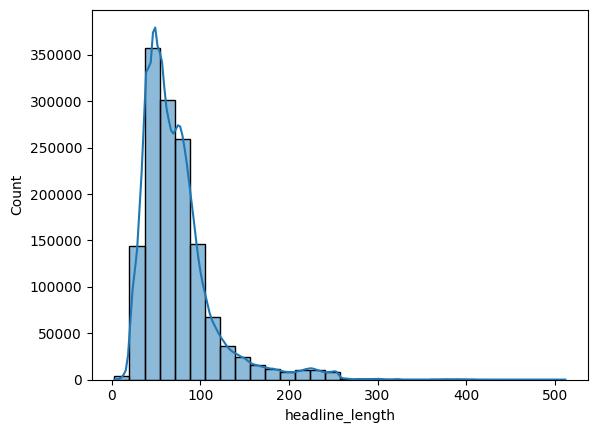

In [65]:
# Example: Analyze headline length
news_data['headline_length'] = news_data['headline'].str.len()
sns.histplot(news_data['headline_length'], bins=30, kde=True)
plt.show()


In [ ]:

sns.countplot(data=news_data, x='sentiment_category', palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Headlines')
plt.show()


In [ ]:
#  Extract Common Keywords or Phrases

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=20)

# Fit and transform headlines
tfidf_matrix = tfidf.fit_transform(news_data['headline'])
top_keywords = tfidf.get_feature_names_out()

print("Top Keywords:", top_keywords)


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Initialize LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 topics
lda.fit(tfidf_matrix)

# Display top words for each topic
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}:")
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


In [ ]:
# save the result 
news_data.to_csv("../data/processed_sentiment_topic_modeling.csv", index=False)


In [83]:
# topic modeling

import os


yfinance_data_dir = '../data/yfinance_data/'
csv_files = [f for f in os.listdir(yfinance_data_dir) if f.endswith('.csv')]
stock_data = {file: pd.read_csv(os.path.join(yfinance_data_dir, file)) for file in csv_files}
print(stock_data['AAPL_historical_data.csv'].head())  # Checking the data for AAPL


         Date      Open      High       Low     Close  Adj Close     Volume  \
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600   
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000   
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600   
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  


In [33]:
news_data['date'] = pd.to_datetime(news_data['date'], errors='coerce')
print(news_data['date'].isnull().sum())  # Check for invalid entries


1351341


In [ ]:
print(news_data['date'].dtypes)
print(news_data['date'].head())


In [ ]:
news_data['publication_date'] = news_data['date'].dt.date
daily_publication_counts = news_data['publication_date'].value_counts().sort_index()

import matplotlib.pyplot as plt

plt.figure(dpi= 200, figsize=(12, 6))
daily_publication_counts.plot(kind='line', title="Daily Publication Trends")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.grid()
plt.show()


In [ ]:
news_data.head()

In [ ]:
publisher_counts = news_data['publisher'].value_counts()
print(publisher_counts.head(10))  # Display the top 10 publishers


publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top_publishers = publisher_counts.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_publishers.index, y=top_publishers.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 Publishers by Article Count")
plt.xlabel("Publisher")
plt.ylabel("Number of Articles")
plt.show()


In [ ]:
for publisher in top_publishers.index:
    print(f"\nHeadlines for {publisher}:")
    print(news_data[news_data['publisher'] == publisher]['headline'].head(5))  # Show 5 sample headlines


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Analyze content for a specific publisher
selected_publisher = top_publishers.index[0]  # Example: the most frequent publisher
publisher_headlines = news_data[news_data['publisher'] == selected_publisher]['headline']

tfidf = TfidfVectorizer(stop_words='english', max_features=20)
tfidf_matrix = tfidf.fit_transform(publisher_headlines)
print(f"Top Keywords for {selected_publisher}: {tfidf.get_feature_names_out()}")


In [17]:
news_data['publisher_domain'] = news_data['publisher'].apply(
    lambda x: x.split('@')[-1] if '@' in x else None
)
domain_counts = news_data['publisher_domain'].value_counts()
print(domain_counts.head(10))  # Display the top 10 domains



publisher_domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


In [ ]:
top_domains = domain_counts.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_domains.index, y=top_domains.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Top 10 Email Domains by Article Count")
plt.xlabel("Domain")
plt.ylabel("Number of Articles")
plt.show()


In [14]:
import os
import pandas as pd

# Path to the yfinance_data folder
data_folder = "../data/yfinance_data"

# List all CSV files in the folder
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

# Load each file into a dictionary
stock_data = {
    file.split('_')[0]: pd.read_csv(os.path.join(data_folder, file)) for file in csv_files
}

# Display the first few rows of a loaded DataFrame (e.g., AAPL)
print(stock_data['AAPL'].head())


         Date      Open      High       Low     Close  Adj Close     Volume  \
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600   
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000   
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600   
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  


In [8]:
import pandas as pd
import os

# Define the data folder path
data_folder = "../data/yfinance_data"

# Initialize an empty dictionary to store stock DataFrames
data = {}

# Load all CSV files in the yfinance_data folder
for file in os.listdir(data_folder):
    if file.endswith("_historical_data.csv"):
        stock_symbol = file.split("_")[0]  # Extract stock symbol from file name
        file_path = os.path.join(data_folder, file)
        df = pd.read_csv(file_path)
        df['Ticker'] = stock_symbol  # Add a column for the stock symbol
        data[stock_symbol] = df

# Combine all data into one DataFrame
stock_data = pd.concat(data.values(), ignore_index=True)
print(stock_data.head())


         Date      Open      High       Low     Close  Adj Close     Volume  \
0  2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500   
1  2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500   
2  2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000   
3  2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000   
4  2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500   

   Dividends  Stock Splits Ticker  
0        0.0           0.0   TSLA  
1        0.0           0.0   TSLA  
2        0.0           0.0   TSLA  
3        0.0           0.0   TSLA  
4        0.0           0.0   TSLA  


In [9]:
import talib

# Apply technical indicators for each stock
indicators = []
for stock_symbol, df in data.items():
    # Ensure 'Close' column is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    
    # Simple Moving Average (SMA)
    df['SMA_50'] = talib.SMA(df['Close'], timeperiod=50)
    
    # Relative Strength Index (RSI)
    df['RSI_14'] = talib.RSI(df['Close'], timeperiod=14)
    
    # Moving Average Convergence Divergence (MACD)
    df['MACD'], df['Signal_Line'], df['Histogram'] = talib.MACD(
        df['Close'], fastperiod=12, slowperiod=26, signalperiod=9
    )
    
    indicators.append(df)

# Combine updated stock data
stock_data_indicators = pd.concat(indicators, ignore_index=True)
print(stock_data_indicators.head())


         Date      Open      High       Low     Close  Adj Close     Volume  \
0  2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500   
1  2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500   
2  2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000   
3  2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000   
4  2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500   

   Dividends  Stock Splits Ticker  SMA_50  RSI_14  MACD  Signal_Line  \
0        0.0           0.0   TSLA     NaN     NaN   NaN          NaN   
1        0.0           0.0   TSLA     NaN     NaN   NaN          NaN   
2        0.0           0.0   TSLA     NaN     NaN   NaN          NaN   
3        0.0           0.0   TSLA     NaN     NaN   NaN          NaN   
4        0.0           0.0   TSLA     NaN     NaN   NaN          NaN   

   Histogram  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  


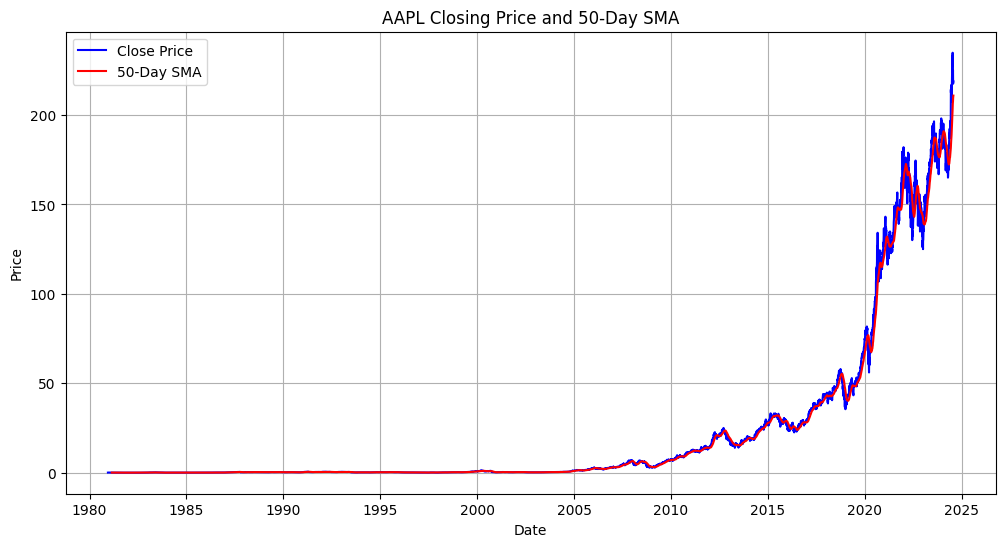

In [105]:
# Ensure 'Date' is in datetime format
aapl_data = data['AAPL']  # Replace 'AAPL' with the desired stock symbol
aapl_data['Date'] = pd.to_datetime(aapl_data['Date'])  
aapl_data['Date'] = pd.to_datetime(aapl_data['Date'])

# Plot Closing Price and SMA with Date on x-axis
plt.figure(figsize=(12, 6))
plt.plot(aapl_data['Date'], aapl_data['Close'], label='Close Price', color='blue')
plt.plot(aapl_data['Date'], aapl_data['SMA_50'], label='50-Day SMA', color='red')
plt.title('AAPL Closing Price and 50-Day SMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


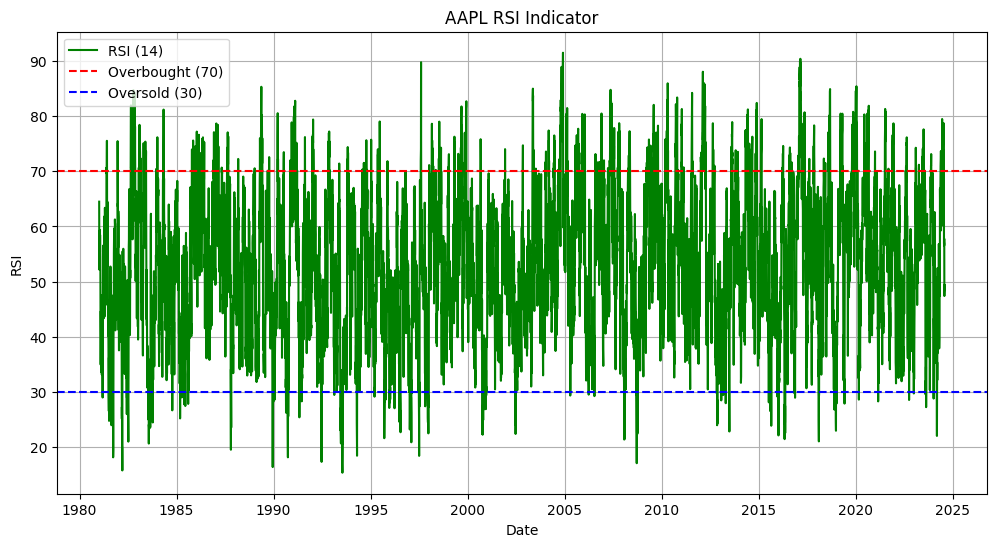

In [ ]:
# Plot RSI with Date on x-axis
aapl_data = data['AAPL']  # Replace 'AAPL' with the desired stock symbol
aapl_data['Date'] = pd.to_datetime(aapl_data['Date'])  
plt.figure(figsize=(12, 6))
plt.plot(aapl_data['Date'], aapl_data['RSI_14'], label='RSI (14)', color='green')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='blue', linestyle='--', label='Oversold (30)')
plt.title('AAPL RSI Indicator')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid()
plt.show()


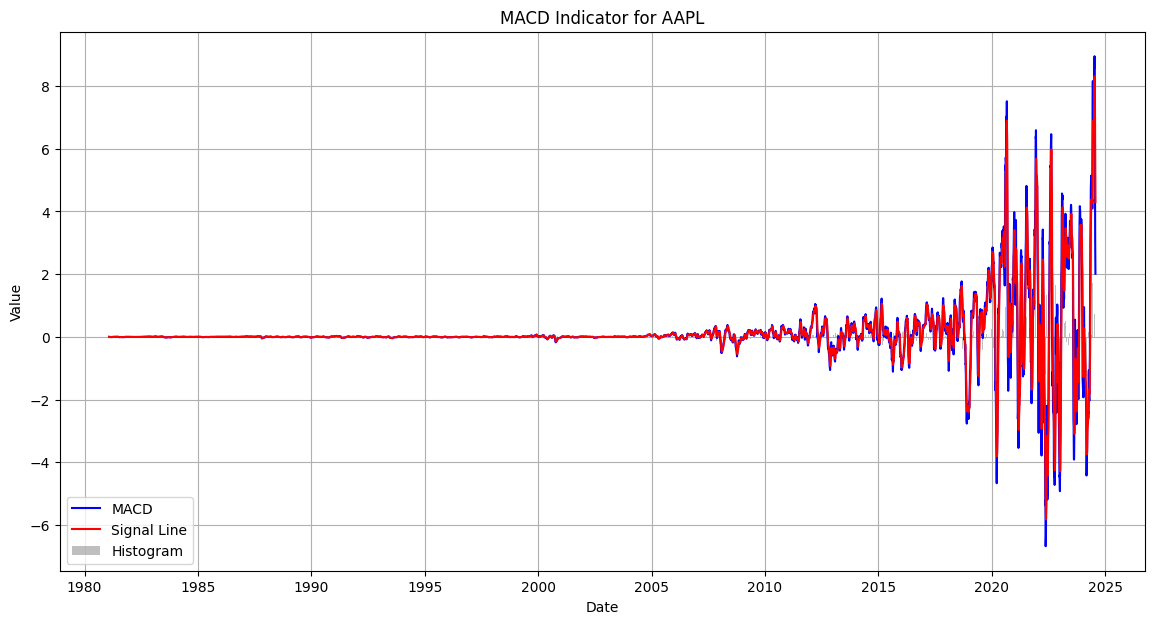

In [10]:
import matplotlib.pyplot as plt
import talib

# Load data for a specific stock (e.g., AAPL)
aapl_data = data['AAPL']  # Replace 'AAPL' with the desired stock symbol
aapl_data['Date'] = pd.to_datetime(aapl_data['Date'])  # Ensure 'Date' is a datetime type

# Calculate MACD, Signal Line, and Histogram
aapl_data['MACD'], aapl_data['Signal_Line'], aapl_data['Histogram'] = talib.MACD(
    aapl_data['Close'], fastperiod=12, slowperiod=26, signalperiod=9
)

# Plot the MACD, Signal Line, and Histogram
plt.figure(figsize=(14, 7))

# Plot MACD and Signal Line
plt.plot(aapl_data['Date'], aapl_data['MACD'], label='MACD', color='blue')
plt.plot(aapl_data['Date'], aapl_data['Signal_Line'], label='Signal Line', color='red')

# Plot Histogram as bars
plt.bar(aapl_data['Date'], aapl_data['Histogram'], label='Histogram', color='gray', alpha=0.5)

# Add labels and title
plt.title('MACD Indicator for AAPL')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()


In [18]:
# Check columns for a specific stock (e.g., AAPL)
print(data['AAPL'].columns)

# Check news dataset
print(news_data.columns)


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits', 'Ticker', 'SMA_50', 'RSI_14', 'MACD',
       'Signal_Line', 'Histogram'],
      dtype='object')
Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock',
       'publisher_domain'],
      dtype='object')


In [39]:
import pandas as pd

# Combine all stock DataFrames into one DataFrame
combined_stock_data = pd.concat(data.values(), ignore_index=True)

# Convert the 'Date' column to datetime format
combined_stock_data['Date'] = pd.to_datetime(combined_stock_data['Date'])

# Verify
print(combined_stock_data[['Date', 'Ticker', 'Close']].head())


        Date Ticker     Close
0 2010-06-29   TSLA  1.592667
1 2010-06-30   TSLA  1.588667
2 2010-07-01   TSLA  1.464000
3 2010-07-02   TSLA  1.280000
4 2010-07-06   TSLA  1.074000


In [40]:
# Convert the 'date' column in news_data to datetime format
news_data['date'] = pd.to_datetime(news_data['date'])

# Verify
print(news_data[['date', 'headline']].head())


                 date                                           headline
0 2020-06-05 10:30:54            Stocks That Hit 52-Week Highs On Friday
1 2020-06-03 10:45:20         Stocks That Hit 52-Week Highs On Wednesday
2 2020-05-26 04:30:07                      71 Biggest Movers From Friday
3 2020-05-22 12:45:06       46 Stocks Moving In Friday's Mid-Day Session
4 2020-05-22 11:38:59  B of A Securities Maintains Neutral on Agilent...


In [42]:
# If 'news_data['date']' has time and you want to match only the date part, remove the time part
news_data['date'] = news_data['date'].dt.date

# Ensure both 'Date' columns are in the same format (datetime.date)
combined_stock_data['Date'] = pd.to_datetime(combined_stock_data['Date']).dt.date

# Merge datasets again
aligned_data = pd.merge(
    combined_stock_data, 
    news_data, 
    left_on='Date', 
    right_on='date', 
    how='inner'
)

# Check the merged data
print(aligned_data[['Date', 'Close', 'headline']].head())


         Date     Close                                           headline
0  2011-04-27  1.805333  ETFs To Watch April 28, 2011 (DGP, IEO, PRN, IDX)
1  2011-04-28  1.844000  Dejour Extends Credit Facility to October 31st...
2  2011-04-28  1.844000                A New Regional Emerging Markets ETF
3  2011-04-29  1.840000        ETF Showdown: Crouching Tigers, Hidden ETFs
4  2011-04-29  1.840000  The GDL Fund to Redeem Its Outstanding 8.50% S...


In [43]:
# Assuming stock_data and news_data are already loaded

# Convert dates to datetime format
combined_stock_data['Date'] = pd.to_datetime(combined_stock_data['Date'])
news_data['date'] = pd.to_datetime(news_data['date'])

# Merge datasets on the 'Date' column (or 'date' in the news dataset)
merged_data = pd.merge(combined_stock_data, news_data, left_on='Date', right_on='date', how='inner')

# Check the merged data
print(merged_data.head())


        Date      Open   High       Low     Close  Adj Close    Volume  \
0 2011-04-27  1.795333  1.824  1.775333  1.805333   1.805333  14953500   
1 2011-04-28  1.804667  1.846  1.781333  1.844000   1.844000  24000000   
2 2011-04-28  1.804667  1.846  1.781333  1.844000   1.844000  24000000   
3 2011-04-29  1.846000  1.858  1.828000  1.840000   1.840000  10890000   
4 2011-04-29  1.846000  1.858  1.828000  1.840000   1.840000  10890000   

   Dividends  Stock Splits Ticker  ...      MACD  Signal_Line  Histogram  \
0        0.0           0.0   TSLA  ...  0.040121     0.033111   0.007010   
1        0.0           0.0   TSLA  ...  0.045615     0.035611   0.010003   
2        0.0           0.0   TSLA  ...  0.045615     0.035611   0.010003   
3        0.0           0.0   TSLA  ...  0.049081     0.038305   0.010775   
4        0.0           0.0   TSLA  ...  0.049081     0.038305   0.010775   

   Unnamed: 0                                           headline  \
0      357064  ETFs To Watch A

In [44]:
from textblob import TextBlob

# Function to calculate sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to the 'headline' column
merged_data['sentiment'] = merged_data['headline'].apply(get_sentiment)

# Show the data with sentiment scores
print(merged_data[['headline', 'sentiment']].head())


                                            headline  sentiment
0  ETFs To Watch April 28, 2011 (DGP, IEO, PRN, IDX)   0.000000
1  Dejour Extends Credit Facility to October 31st...   0.000000
2                A New Regional Emerging Markets ETF   0.136364
3        ETF Showdown: Crouching Tigers, Hidden ETFs  -0.166667
4  The GDL Fund to Redeem Its Outstanding 8.50% S...   0.500000


In [45]:
# Calculate daily stock returns (percentage change in closing prices)
merged_data['daily_return'] = merged_data['Close'].pct_change() * 100  # Percentage change
print(merged_data[['Date', 'Close', 'daily_return']].head())


        Date     Close  daily_return
0 2011-04-27  1.805333           NaN
1 2011-04-28  1.844000      2.141819
2 2011-04-28  1.844000      0.000000
3 2011-04-29  1.840000     -0.216917
4 2011-04-29  1.840000      0.000000


In [46]:
#Aggregate Sentiments
# Group by Date and calculate average sentiment for each day
daily_sentiment = merged_data.groupby('Date')['sentiment'].mean().reset_index()

# Merge average sentiment back into the main data (to calculate correlation later)
merged_data = pd.merge(merged_data, daily_sentiment, on='Date', suffixes=('', '_avg'))

print(merged_data[['Date', 'sentiment', 'sentiment_avg']].head())


        Date  sentiment  sentiment_avg
0 2011-04-27   0.000000       0.000000
1 2011-04-28   0.000000       0.068182
2 2011-04-28   0.136364       0.068182
3 2011-04-29  -0.166667       0.166667
4 2011-04-29   0.500000       0.166667


In [ ]:
#calculate correlation
# Calculate the Pearson correlation coefficient between average sentiment and daily returns
correlation = merged_data[['sentiment_avg', 'daily_return']].corr().iloc[0, 1]
print(f"Pearson Correlation: {correlation}")
#A positive correlation suggests that positive sentiment correlates with positive stock returns, and vice versa.

Pearson Correlation: 0.003380092407647625


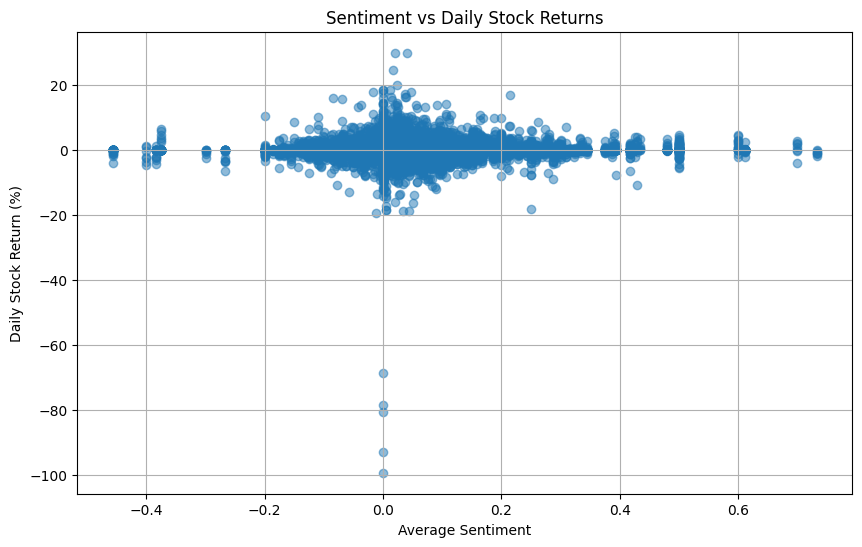

In [49]:
import matplotlib.pyplot as plt

# Plot sentiment vs daily stock return
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['sentiment_avg'], merged_data['daily_return'], alpha=0.5)
plt.title('Sentiment vs Daily Stock Returns')
plt.xlabel('Average Sentiment')
plt.ylabel('Daily Stock Return (%)')
plt.grid(True)
plt.show()
